In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Load all family data
print("Loading clustered family data...")
families = {}
family_gv = {}

for fam_id in range(4):
    try:
        cpv_path = f'/home/raj.ayush/results/clustering_step1/cpv_fam{fam_id}.csv'
        gv_path = f'/home/raj.ayush/results/clustering_step1/gv_fam{fam_id}.csv'
        
        families[fam_id] = pd.read_csv(cpv_path)
        family_gv[fam_id] = pd.read_csv(gv_path)
        
        print(f"Family {fam_id}: {len(families[fam_id])} events, {len(family_gv[fam_id])} grid points")
        
        # Add family identifier
        families[fam_id]['family_id'] = fam_id
        family_gv[fam_id]['family_id'] = fam_id
        
    except FileNotFoundError:
        print(f"Warning: Family {fam_id} files not found")

print(f"\nSuccessfully loaded {len(families)} families")

Loading clustered family data...
Family 0: 1930 events, 2682714 grid points
Family 1: 1377 events, 1708654 grid points
Family 2: 1564 events, 1382552 grid points
Family 3: 1616 events, 2237175 grid points

Successfully loaded 4 families


In [2]:
# Process all families
families_clean = {}

for fam_id, df in families.items():
    # Process datetime columns
    df['time_amin'] = pd.to_datetime(df['time_amin'])
    df['time_amax'] = pd.to_datetime(df['time_amax'])
    df['year'] = df['time_amin'].dt.year
    df['month'] = df['time_amin'].dt.month
    df['day_of_year'] = df['time_amin'].dt.dayofyear
    
    # Filter out unrealistic values
    families_clean[fam_id] = df[
        (df['timespan'] > 0) & 
        (df['timespan'] <= 365) & 
        (df['HWMId_magnitude'] > 0)
    ].copy()
    
    print(f"Family {fam_id}: {len(df)} -> {len(families_clean[fam_id])} events after cleaning")

# Combine all families for comparison
all_families = pd.concat(families_clean.values(), ignore_index=True)
print(f"\nTotal events across all families: {len(all_families)}")

Family 0: 1930 -> 1408 events after cleaning
Family 1: 1377 -> 735 events after cleaning
Family 2: 1564 -> 841 events after cleaning
Family 3: 1616 -> 1414 events after cleaning

Total events across all families: 4398


=== FAMILY COMPARISON OVERVIEW ===


,Family,Events,Mean_Duration,Mean_Magnitude,Std_Duration,Std_Magnitude,Min_Year,Max_Year,Peak_Month,Lat_Center,Lon_Center
0,0,1408,6.024,795.767,5.902,3050.399,1979,2018,7,19.512,86.708
1,1,735,5.922,616.309,4.435,3888.967,1979,2018,3,0.451,88.047
2,2,841,6.044,246.316,3.672,793.594,1979,2018,10,3.060,93.462
3,3,1414,5.632,1479.144,5.489,19130.846,1979,2018,5,15.438,85.559


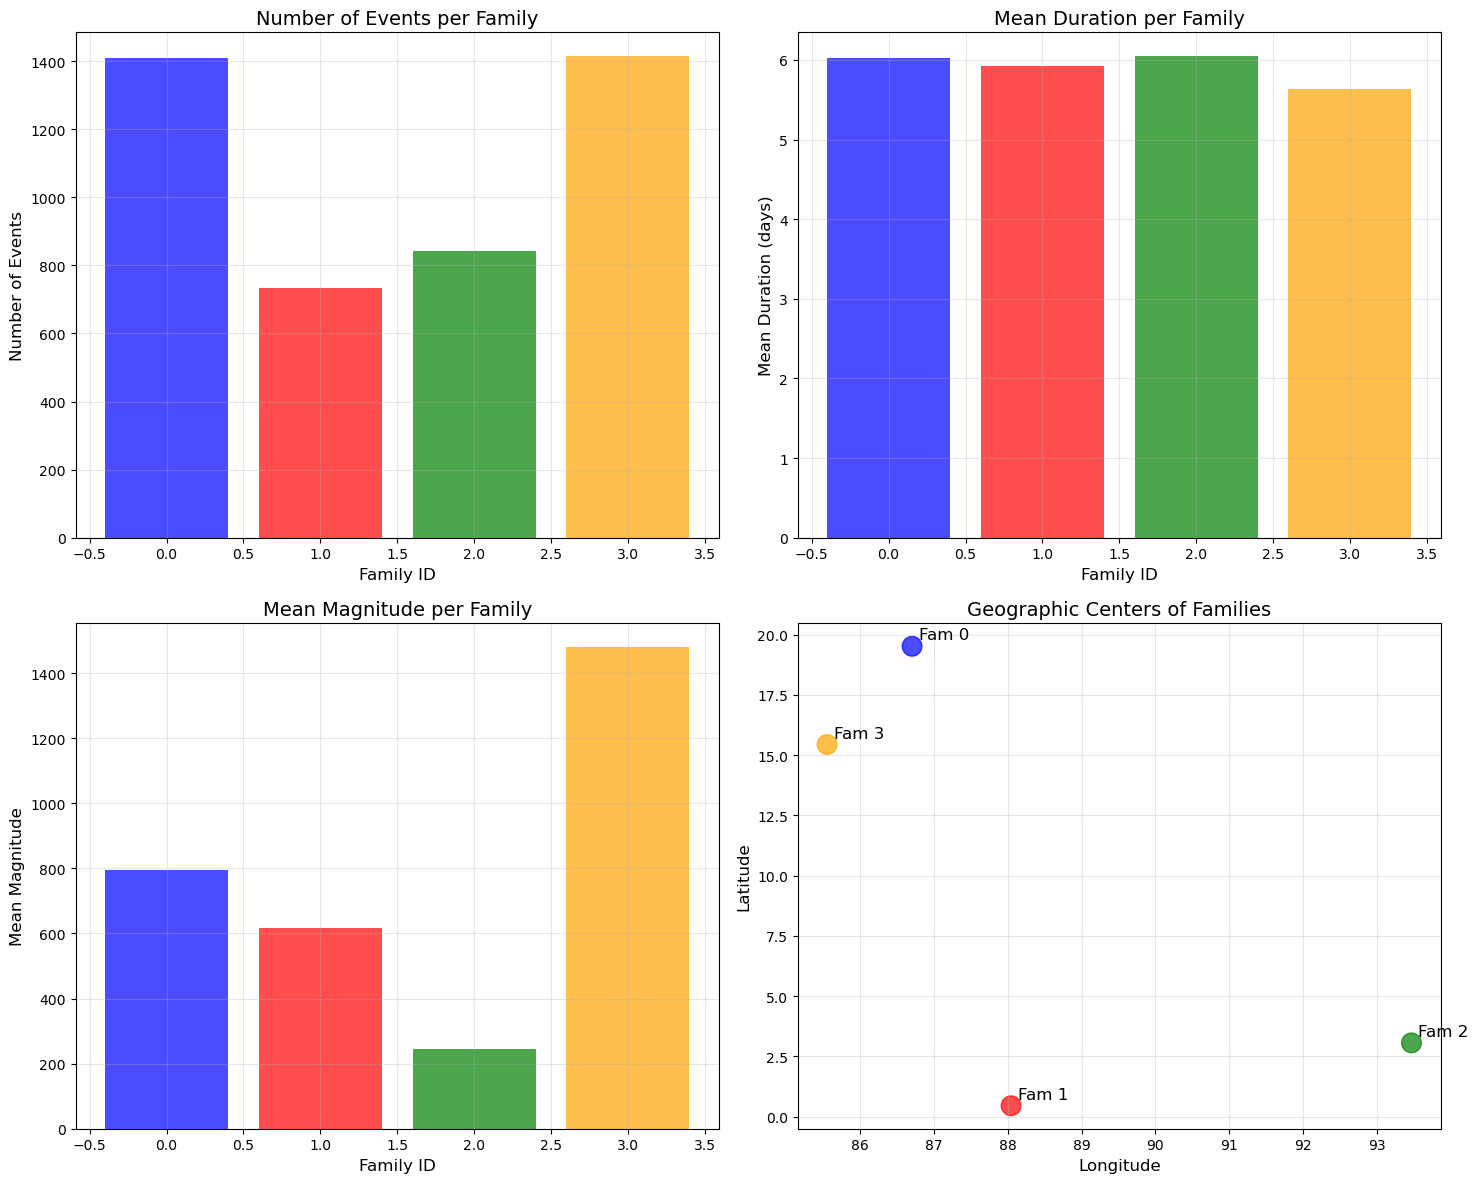

In [4]:
# Family comparison overview
print("=== FAMILY COMPARISON OVERVIEW ===")

family_stats = []
for fam_id, df in families_clean.items():
    stats_dict = {
        'Family': fam_id,
        'Events': len(df),
        'Mean_Duration': df['timespan'].mean(),
        'Mean_Magnitude': df['HWMId_magnitude'].mean(),
        'Std_Duration': df['timespan'].std(),
        'Std_Magnitude': df['HWMId_magnitude'].std(),
        'Min_Year': df['year'].min(),
        'Max_Year': df['year'].max(),
        'Peak_Month': df['month'].mode().iloc[0] if len(df) > 0 else None,
        'Lat_Center': df['latitude_mean'].mean(),
        'Lon_Center': df['longitude_mean'].mean()
    }
    family_stats.append(stats_dict)

family_summary = pd.DataFrame(family_stats)
display(family_summary.round(3))

# Visualize family comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Number of events per family
axes[0,0].bar(family_summary['Family'], family_summary['Events'], 
              color=['blue', 'red', 'green', 'orange'], alpha=0.7)
axes[0,0].set_xlabel('Family ID')
axes[0,0].set_ylabel('Number of Events')
axes[0,0].set_title('Number of Events per Family')
axes[0,0].grid(True, alpha=0.3)

# Mean duration comparison
axes[0,1].bar(family_summary['Family'], family_summary['Mean_Duration'], 
              color=['blue', 'red', 'green', 'orange'], alpha=0.7)
axes[0,1].set_xlabel('Family ID')
axes[0,1].set_ylabel('Mean Duration (days)')
axes[0,1].set_title('Mean Duration per Family')
axes[0,1].grid(True, alpha=0.3)

# Mean magnitude comparison
axes[1,0].bar(family_summary['Family'], family_summary['Mean_Magnitude'], 
              color=['blue', 'red', 'green', 'orange'], alpha=0.7)
axes[1,0].set_xlabel('Family ID')
axes[1,0].set_ylabel('Mean Magnitude')
axes[1,0].set_title('Mean Magnitude per Family')
axes[1,0].grid(True, alpha=0.3)

# Geographic centers
axes[1,1].scatter(family_summary['Lon_Center'], family_summary['Lat_Center'],
                  c=['blue', 'red', 'green', 'orange'], s=200, alpha=0.7)
for i, txt in enumerate(family_summary['Family']):
    axes[1,1].annotate(f'Fam {txt}', 
                       (family_summary['Lon_Center'].iloc[i], family_summary['Lat_Center'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')
axes[1,1].set_title('Geographic Centers of Families')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_overview_comparison.png')
plt.show()

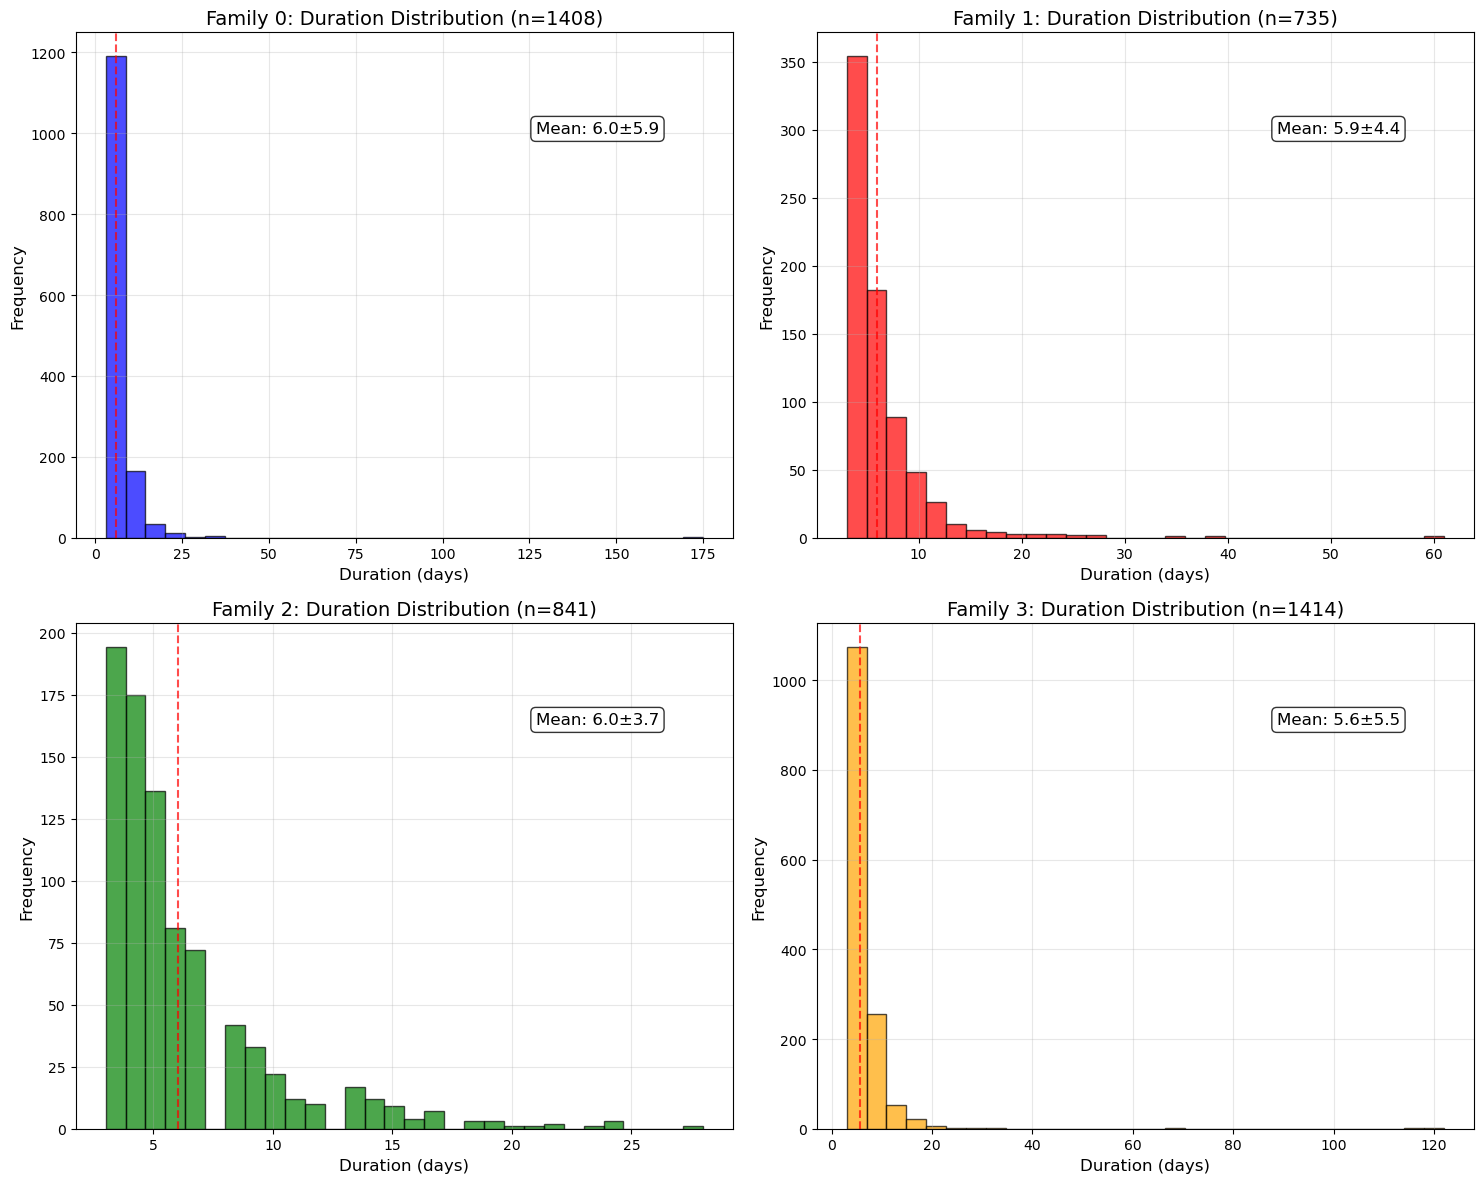

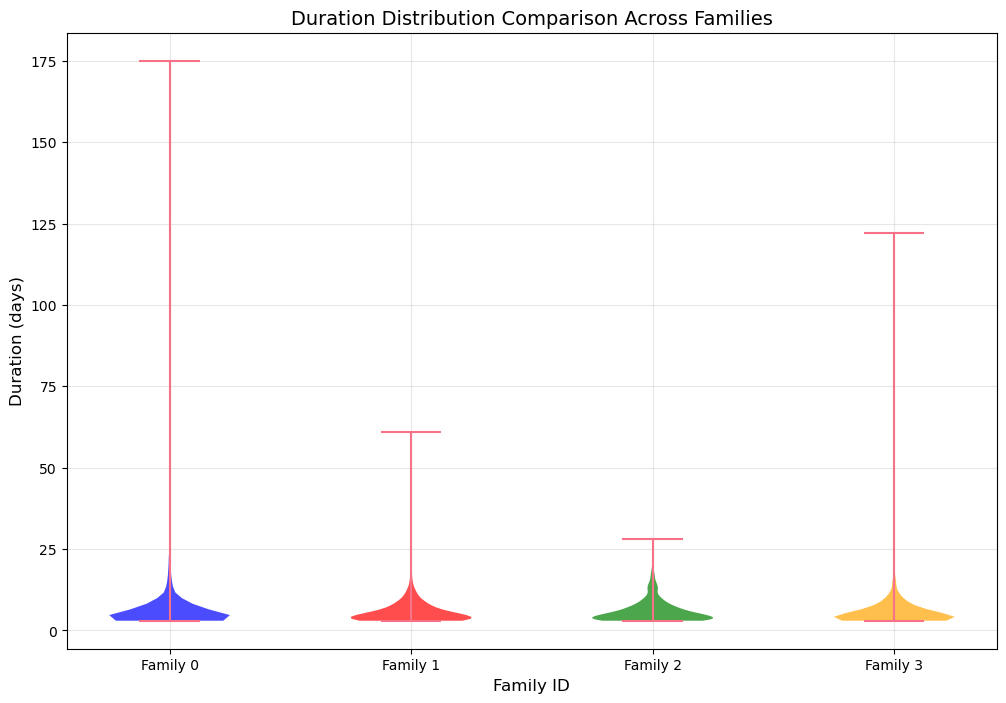

In [6]:
# Duration distributions for all families
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual histograms
colors = ['blue', 'red', 'green', 'orange']
for i, (fam_id, df) in enumerate(families_clean.items()):
    axes[i//2, i%2].hist(df['timespan'], bins=30, alpha=0.7, 
                         color=colors[i], edgecolor='black', label=f'Family {fam_id}')
    axes[i//2, i%2].set_xlabel('Duration (days)')
    axes[i//2, i%2].set_ylabel('Frequency')
    axes[i//2, i%2].set_title(f'Family {fam_id}: Duration Distribution (n={len(df)})')
    axes[i//2, i%2].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_dur = df['timespan'].mean()
    std_dur = df['timespan'].std()
    axes[i//2, i%2].axvline(mean_dur, color='red', linestyle='--', alpha=0.7)
    axes[i//2, i%2].text(0.7, 0.8, f'Mean: {mean_dur:.1f}±{std_dur:.1f}', 
                         transform=axes[i//2, i%2].transAxes,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_duration_distributions.png')
plt.show()

# Combined violin plot
plt.figure(figsize=(12, 8))
duration_data = [families_clean[fam_id]['timespan'].values for fam_id in range(4)]
parts = plt.violinplot(duration_data, positions=range(4))

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

plt.xlabel('Family ID')
plt.ylabel('Duration (days)')
plt.title('Duration Distribution Comparison Across Families')
plt.xticks(range(4), [f'Family {i}' for i in range(4)])
plt.grid(True, alpha=0.3)
plt.savefig('/home/raj.ayush/results/final_ananananal/family_duration_violins.png')
plt.show()

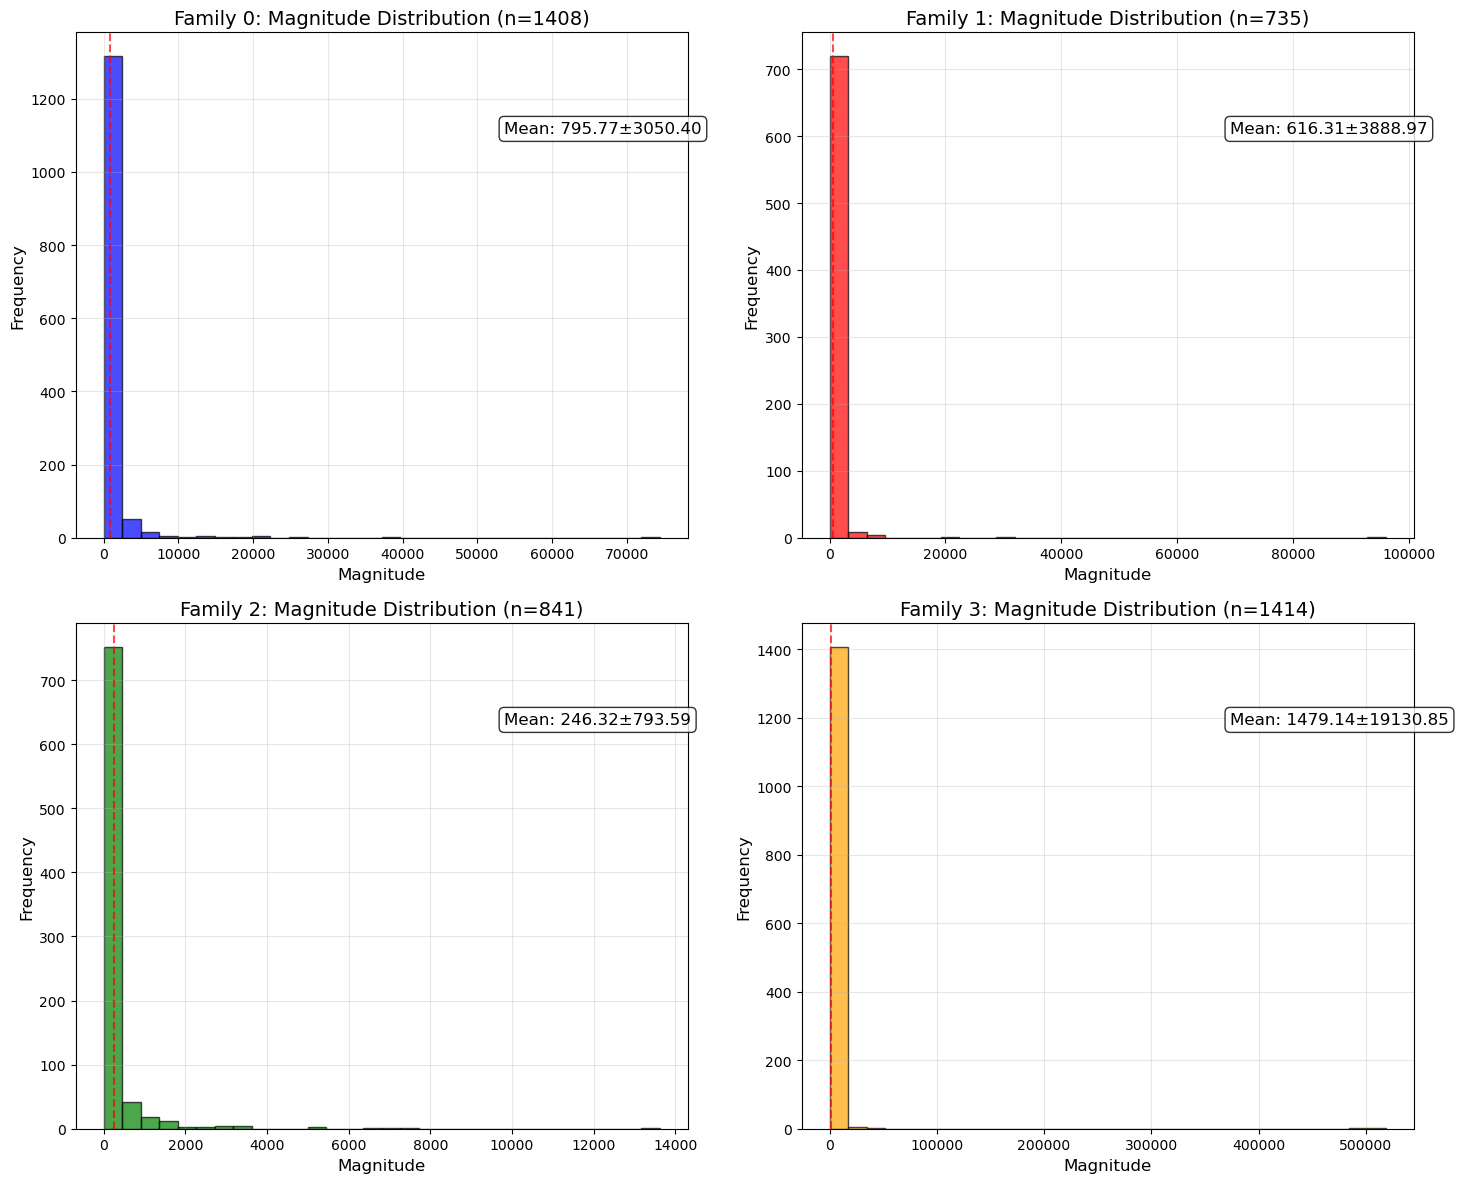

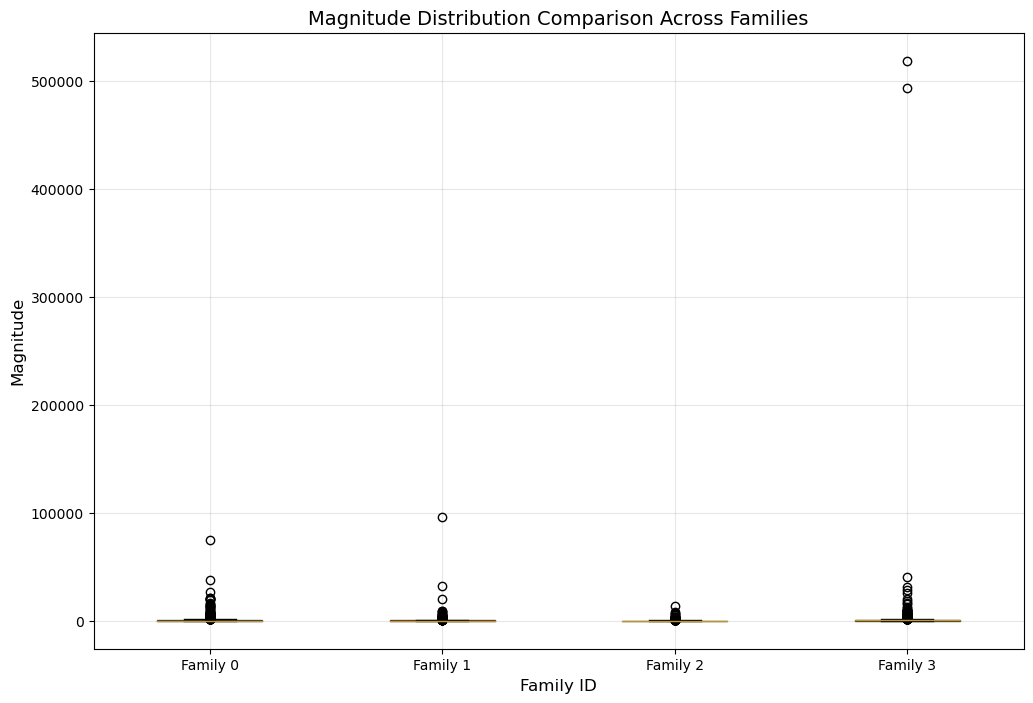

In [9]:
# Magnitude distributions for all families
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual histograms
for i, (fam_id, df) in enumerate(families_clean.items()):
    axes[i//2, i%2].hist(df['HWMId_magnitude'], bins=30, alpha=0.7, 
                         color=colors[i], edgecolor='black')
    axes[i//2, i%2].set_xlabel('Magnitude')
    axes[i//2, i%2].set_ylabel('Frequency')
    axes[i//2, i%2].set_title(f'Family {fam_id}: Magnitude Distribution (n={len(df)})')
    axes[i//2, i%2].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_mag = df['HWMId_magnitude'].mean()
    std_mag = df['HWMId_magnitude'].std()
    axes[i//2, i%2].axvline(mean_mag, color='red', linestyle='--', alpha=0.7)
    axes[i//2, i%2].text(0.7, 0.8, f'Mean: {mean_mag:.2f}±{std_mag:.2f}', 
                         transform=axes[i//2, i%2].transAxes,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_magnitude_distributions.png')
plt.show()

# Combined box plot
plt.figure(figsize=(12, 8))
magnitude_data = [families_clean[fam_id]['HWMId_magnitude'].values for fam_id in range(4)]
bp = plt.boxplot(magnitude_data, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Family ID')
plt.ylabel('Magnitude')
plt.title('Magnitude Distribution Comparison Across Families')
plt.xticks(range(1, 5), [f'Family {i}' for i in range(4)])
plt.grid(True, alpha=0.3)
plt.savefig('/home/raj.ayush/results/final_ananananal/family_magnitude_boxplots.png')
plt.show()

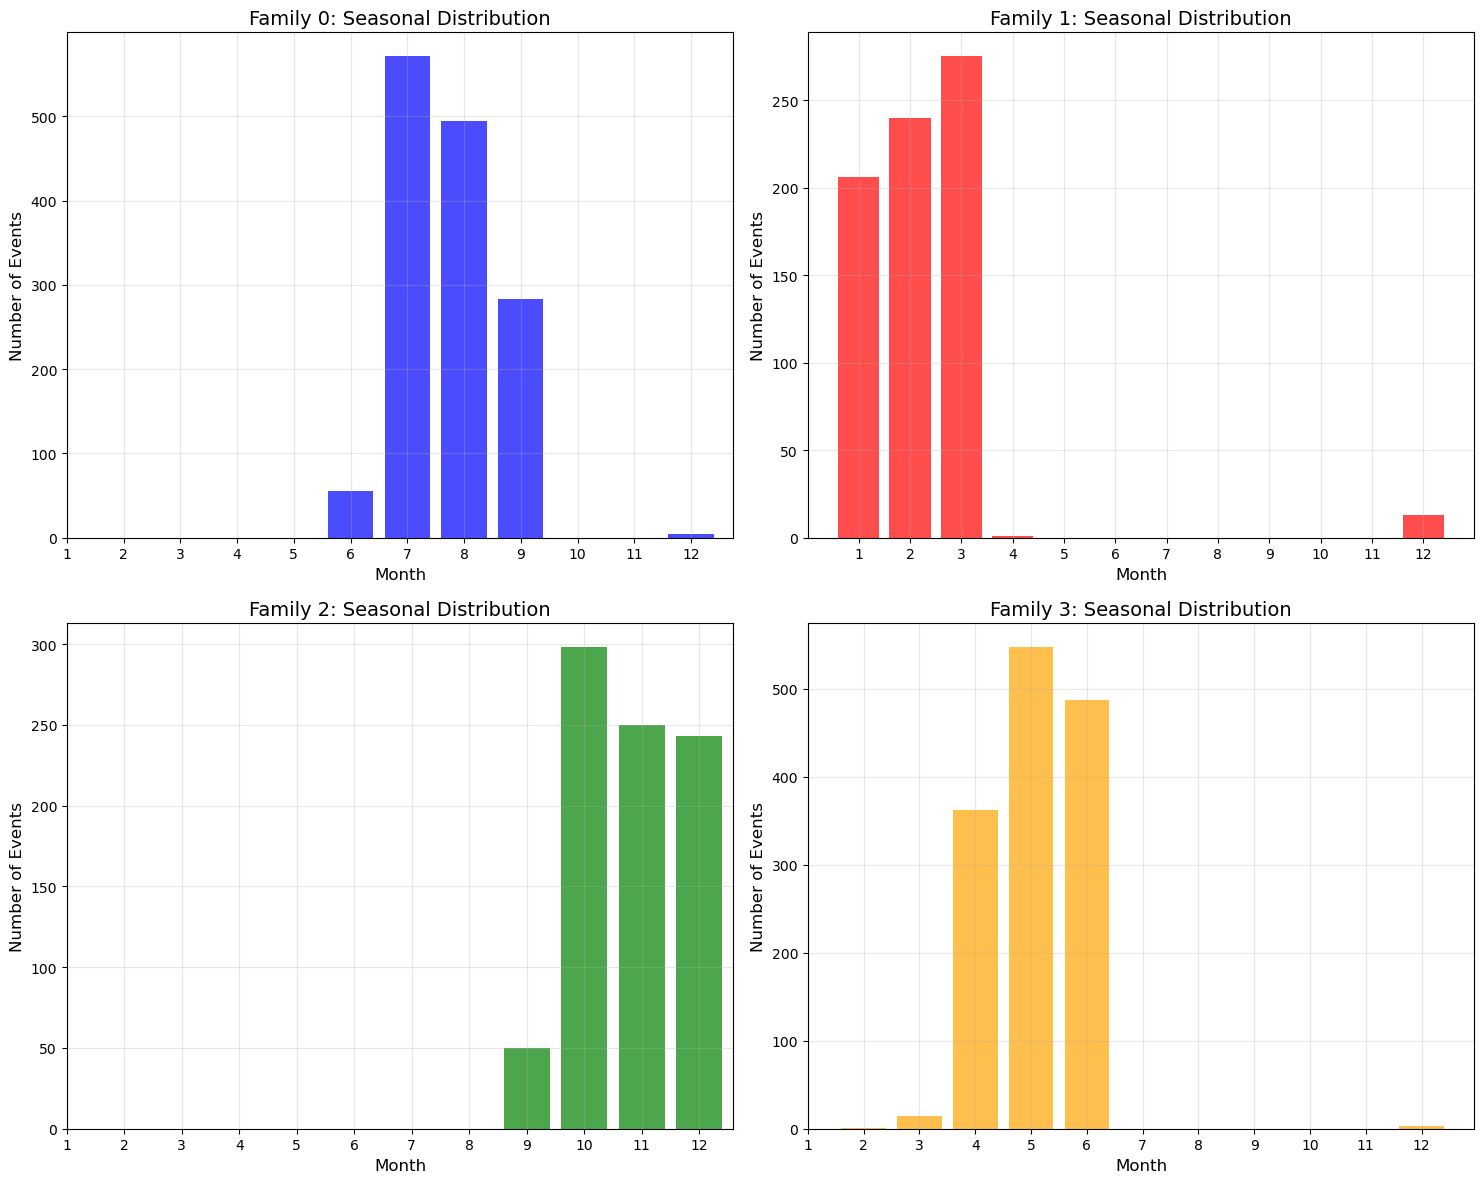

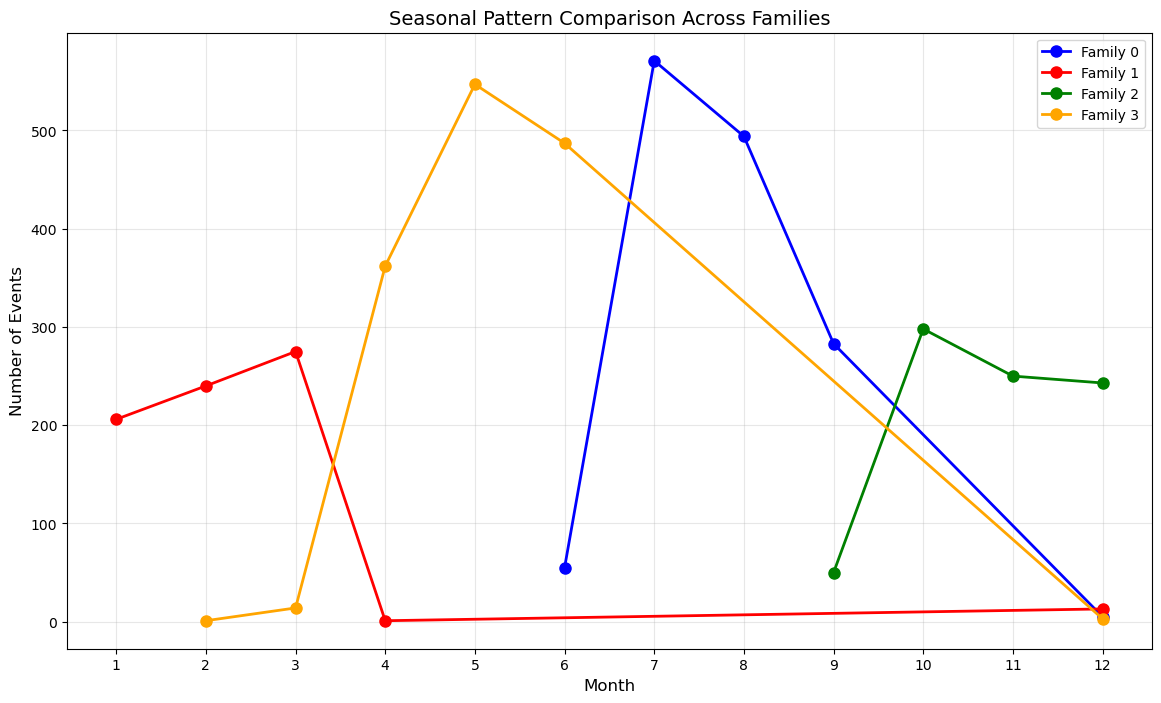

=== SEASONAL PEAK ANALYSIS ===
Family 0: Peak in month 7 (571/1408 events, 40.6%)
Family 1: Peak in month 3 (275/735 events, 37.4%)
Family 2: Peak in month 10 (298/841 events, 35.4%)
Family 3: Peak in month 5 (547/1414 events, 38.7%)


In [11]:
# Seasonal patterns for all families
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Monthly distribution for each family
for i, (fam_id, df) in enumerate(families_clean.items()):
    monthly_counts = df['month'].value_counts().sort_index()
    axes[i//2, i%2].bar(monthly_counts.index, monthly_counts.values, 
                        alpha=0.7, color=colors[i])
    axes[i//2, i%2].set_xlabel('Month')
    axes[i//2, i%2].set_ylabel('Number of Events')
    axes[i//2, i%2].set_title(f'Family {fam_id}: Seasonal Distribution')
    axes[i//2, i%2].set_xticks(range(1, 13))
    axes[i//2, i%2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_seasonal_patterns.png')
plt.show()

# Combined seasonal comparison
plt.figure(figsize=(14, 8))
for fam_id, df in families_clean.items():
    monthly_counts = df['month'].value_counts().sort_index()
    plt.plot(monthly_counts.index, monthly_counts.values, 
             marker='o', linewidth=2, label=f'Family {fam_id}', 
             color=colors[fam_id], markersize=8)

plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.title('Seasonal Pattern Comparison Across Families')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/raj.ayush/results/final_ananananal/family_seasonal_comparison.png')
plt.show()

# Seasonal statistics
print("=== SEASONAL PEAK ANALYSIS ===")
for fam_id, df in families_clean.items():
    monthly_counts = df['month'].value_counts().sort_index()
    peak_month = monthly_counts.idxmax()
    peak_count = monthly_counts.max()
    total_events = len(df)
    peak_percentage = (peak_count / total_events) * 100
    print(f"Family {fam_id}: Peak in month {peak_month} ({peak_count}/{total_events} events, {peak_percentage:.1f}%)")

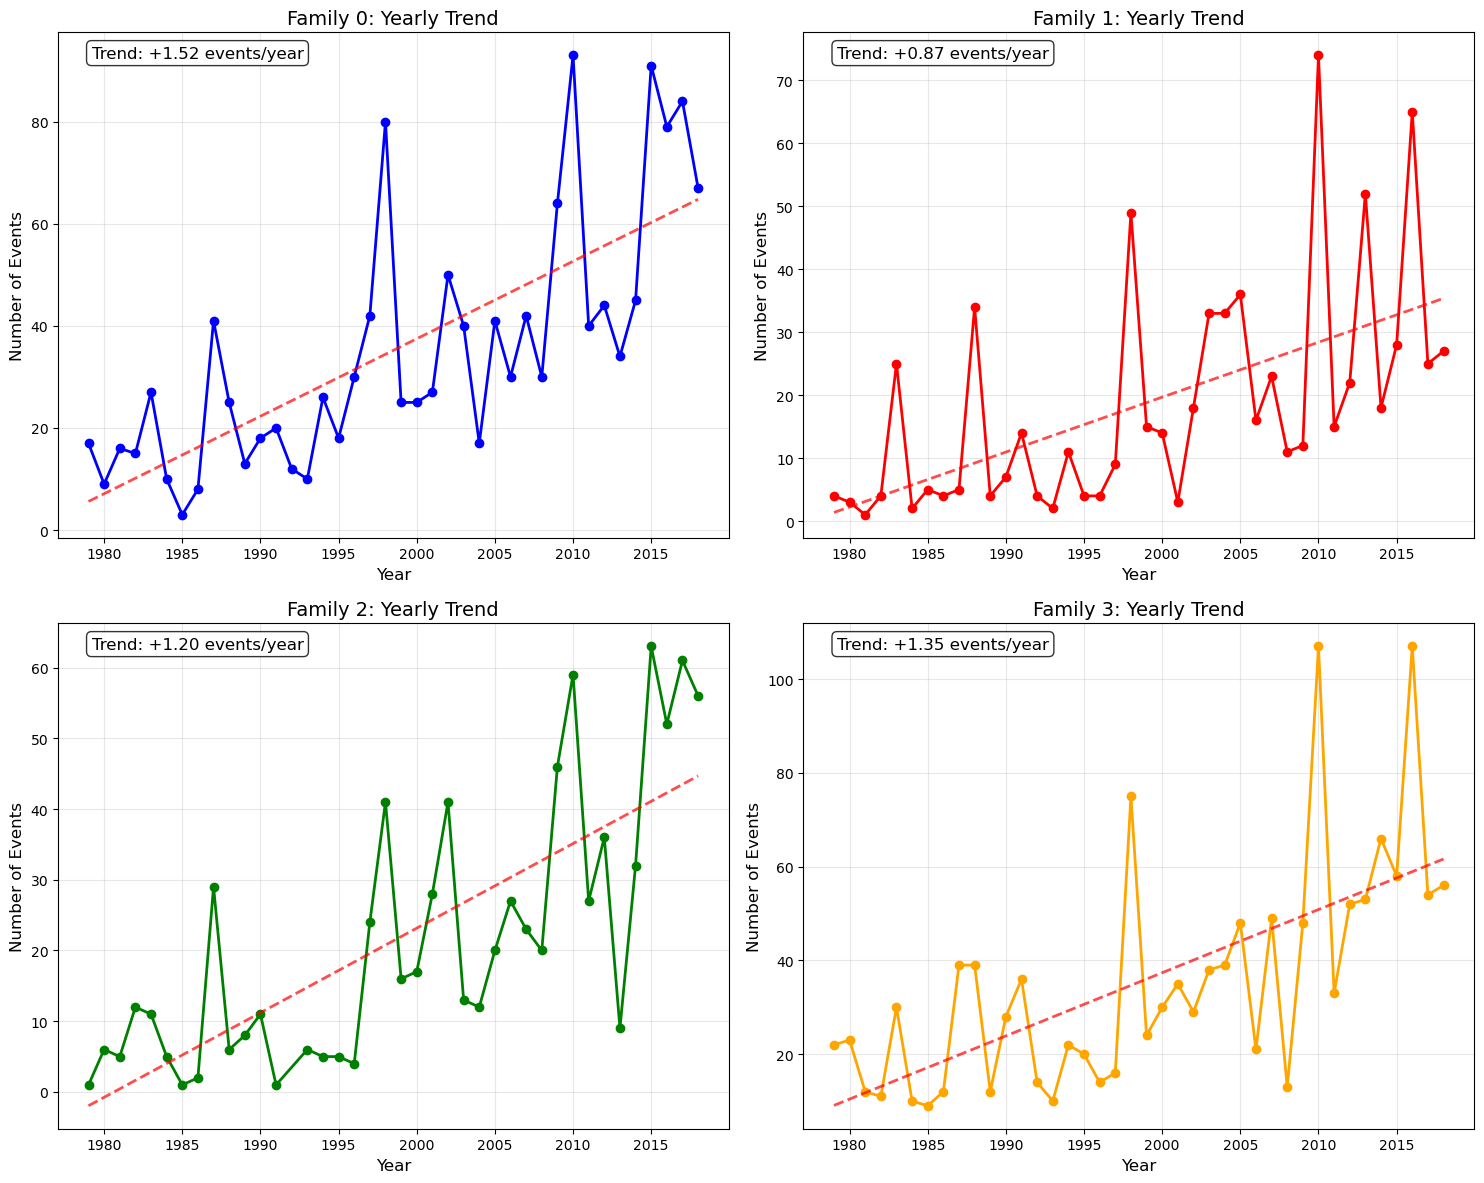

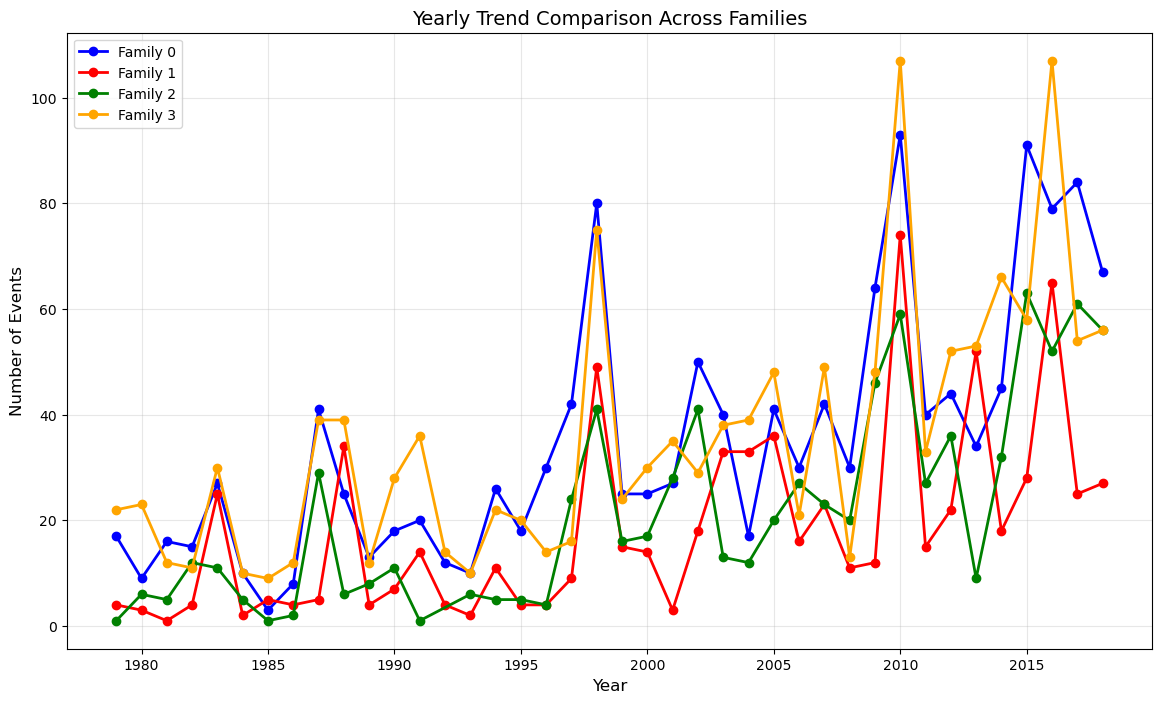

In [13]:
# Yearly trends for all families
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual yearly trends
for i, (fam_id, df) in enumerate(families_clean.items()):
    yearly_counts = df['year'].value_counts().sort_index()
    axes[i//2, i%2].plot(yearly_counts.index, yearly_counts.values, 
                         marker='o', linewidth=2, color=colors[i], markersize=6)
    axes[i//2, i%2].set_xlabel('Year')
    axes[i//2, i%2].set_ylabel('Number of Events')
    axes[i//2, i%2].set_title(f'Family {fam_id}: Yearly Trend')
    axes[i//2, i%2].grid(True, alpha=0.3)
    
    # Add trend line
    if len(yearly_counts) > 1:
        z = np.polyfit(yearly_counts.index, yearly_counts.values, 1)
        p = np.poly1d(z)
        axes[i//2, i%2].plot(yearly_counts.index, p(yearly_counts.index), 
                             "--", color='red', alpha=0.7, linewidth=2)
        slope = z[0]
        axes[i//2, i%2].text(0.05, 0.95, f'Trend: {slope:+.2f} events/year', 
                             transform=axes[i//2, i%2].transAxes,
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_yearly_trends.png')
plt.show()

# Combined yearly comparison
plt.figure(figsize=(14, 8))
for fam_id, df in families_clean.items():
    yearly_counts = df['year'].value_counts().sort_index()
    plt.plot(yearly_counts.index, yearly_counts.values, 
             marker='o', linewidth=2, label=f'Family {fam_id}', 
             color=colors[fam_id], markersize=6)

plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Yearly Trend Comparison Across Families')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/raj.ayush/results/final_ananananal/family_yearly_comparison.png')
plt.show()

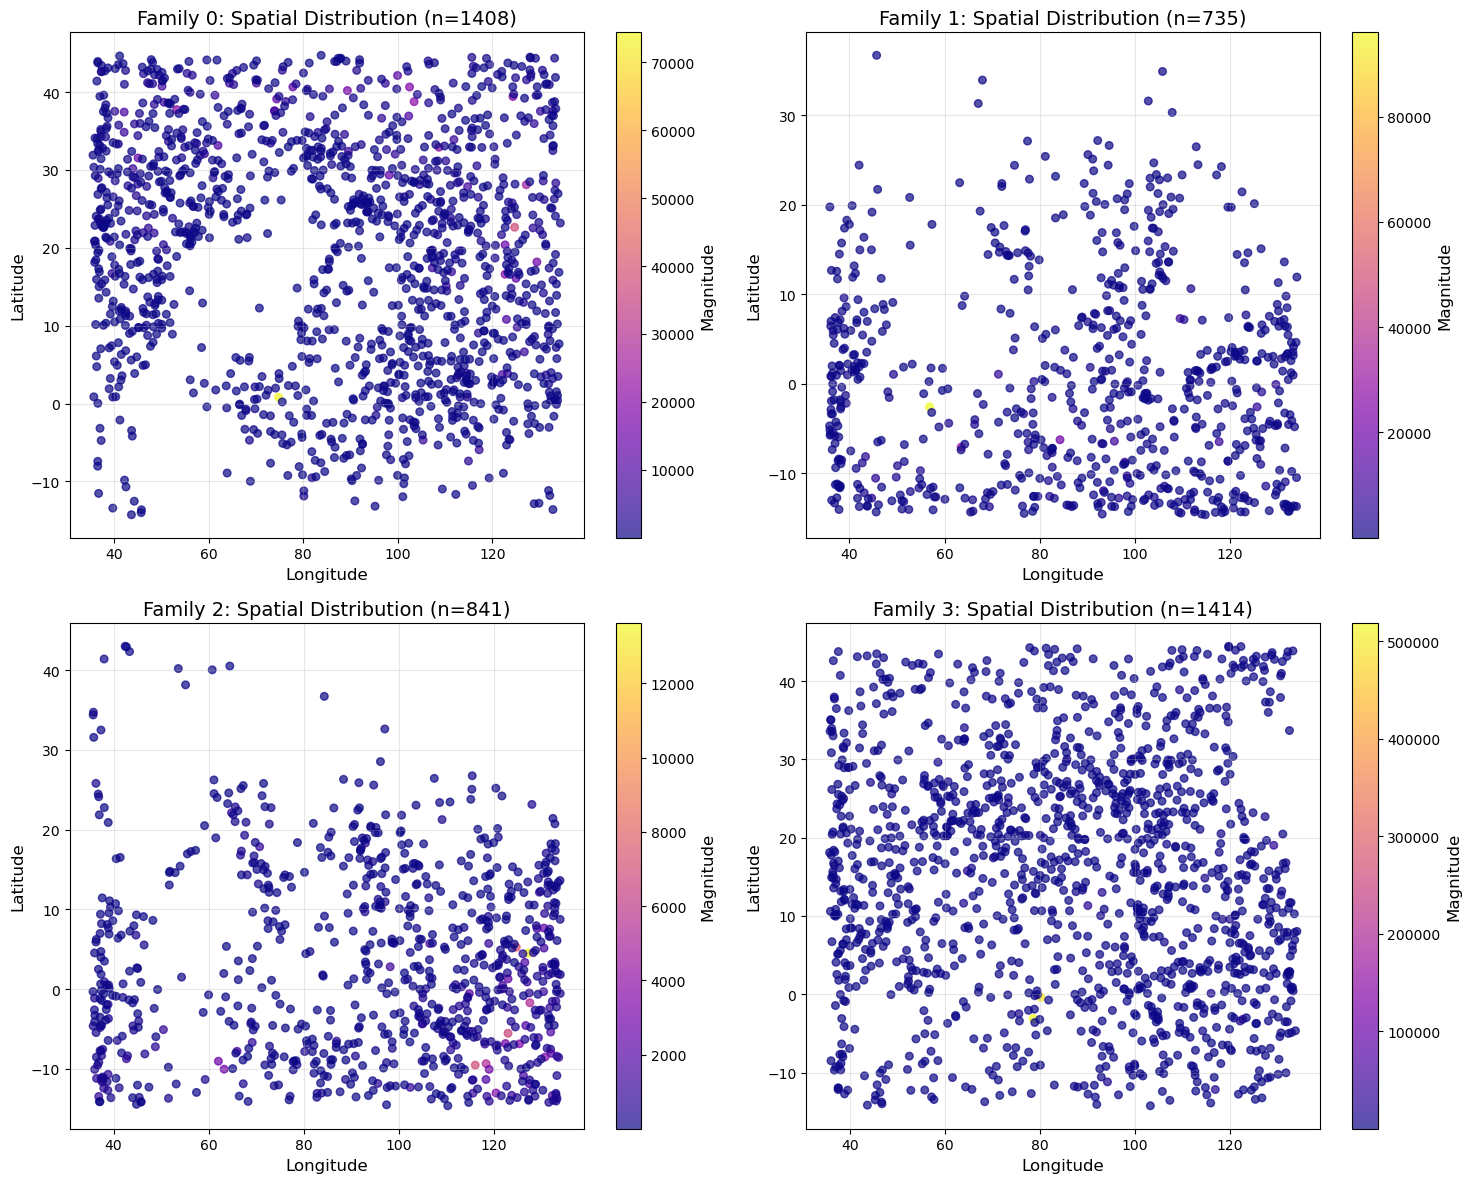

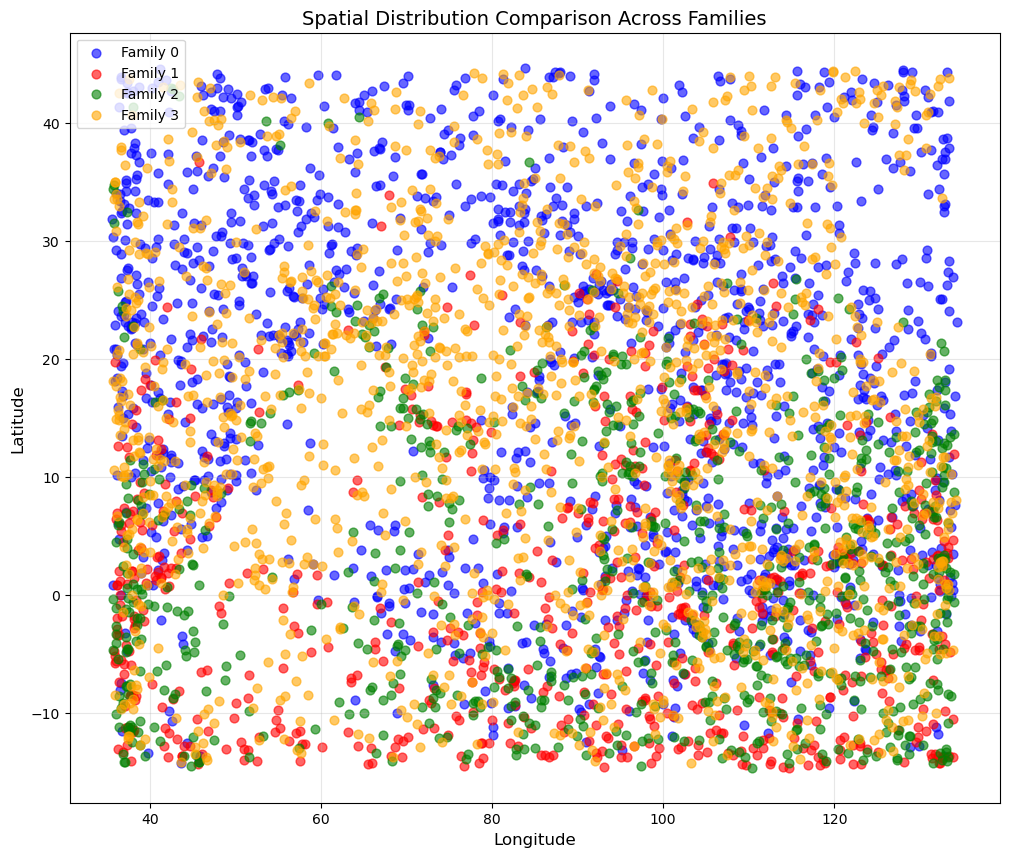

=== SPATIAL CHARACTERISTICS ===
Family 0: Center (19.51, 86.71), Range (lat: 59.00, lon: 98.82)
Family 1: Center (0.45, 88.05), Range (lat: 51.35, lon: 98.16)
Family 2: Center (3.06, 93.46), Range (lat: 57.66, lon: 98.32)
Family 3: Center (15.44, 85.56), Range (lat: 58.68, lon: 98.54)


In [15]:
# Spatial distribution for all families
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual spatial plots
for i, (fam_id, df) in enumerate(families_clean.items()):
    scatter = axes[i//2, i%2].scatter(df['longitude_mean'], df['latitude_mean'], 
                                      c=df['HWMId_magnitude'], cmap='plasma', 
                                      alpha=0.7, s=30)
    axes[i//2, i%2].set_xlabel('Longitude')
    axes[i//2, i%2].set_ylabel('Latitude')
    axes[i//2, i%2].set_title(f'Family {fam_id}: Spatial Distribution (n={len(df)})')
    axes[i//2, i%2].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[i//2, i%2], label='Magnitude')

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_spatial_distributions.png')
plt.show()

# Combined spatial plot
plt.figure(figsize=(12, 10))
for fam_id, df in families_clean.items():
    plt.scatter(df['longitude_mean'], df['latitude_mean'], 
                alpha=0.6, s=40, label=f'Family {fam_id}', 
                color=colors[fam_id])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution Comparison Across Families')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/raj.ayush/results/final_ananananal/family_spatial_comparison.png')
plt.show()

# Spatial statistics
print("=== SPATIAL CHARACTERISTICS ===")
for fam_id, df in families_clean.items():
    lat_range = df['latitude_mean'].max() - df['latitude_mean'].min()
    lon_range = df['longitude_mean'].max() - df['longitude_mean'].min()
    lat_center = df['latitude_mean'].mean()
    lon_center = df['longitude_mean'].mean()
    print(f"Family {fam_id}: Center ({lat_center:.2f}, {lon_center:.2f}), "
          f"Range (lat: {lat_range:.2f}, lon: {lon_range:.2f})")

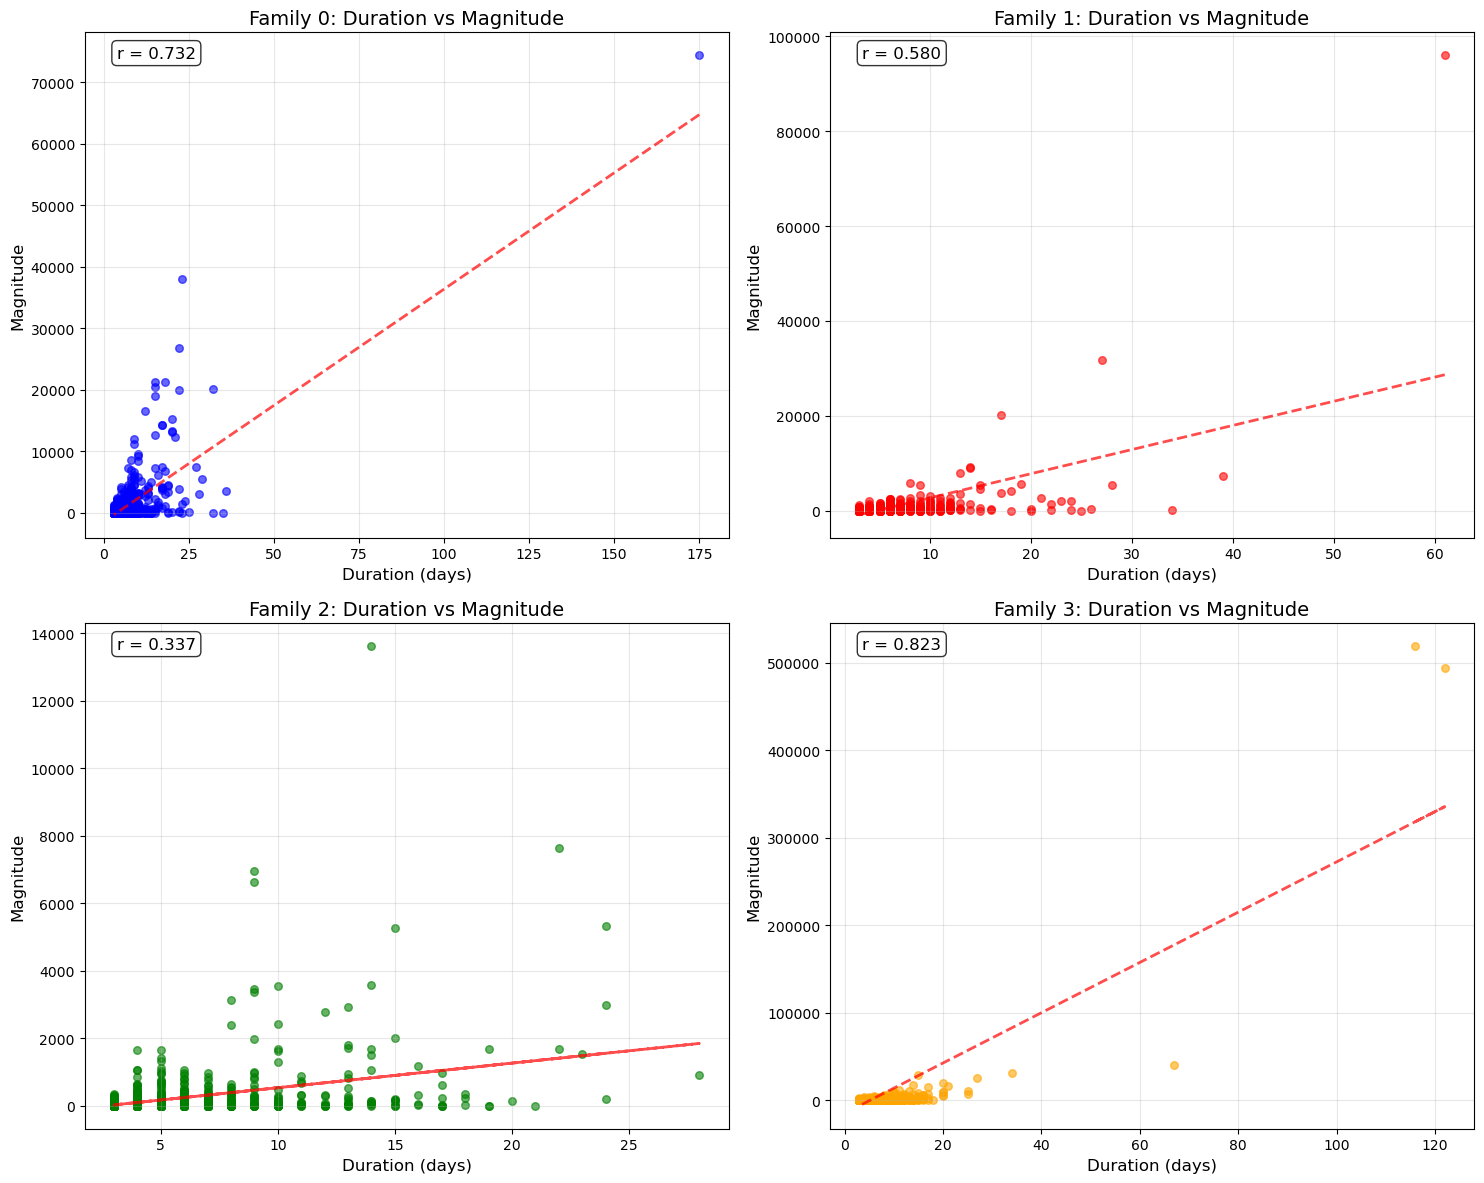

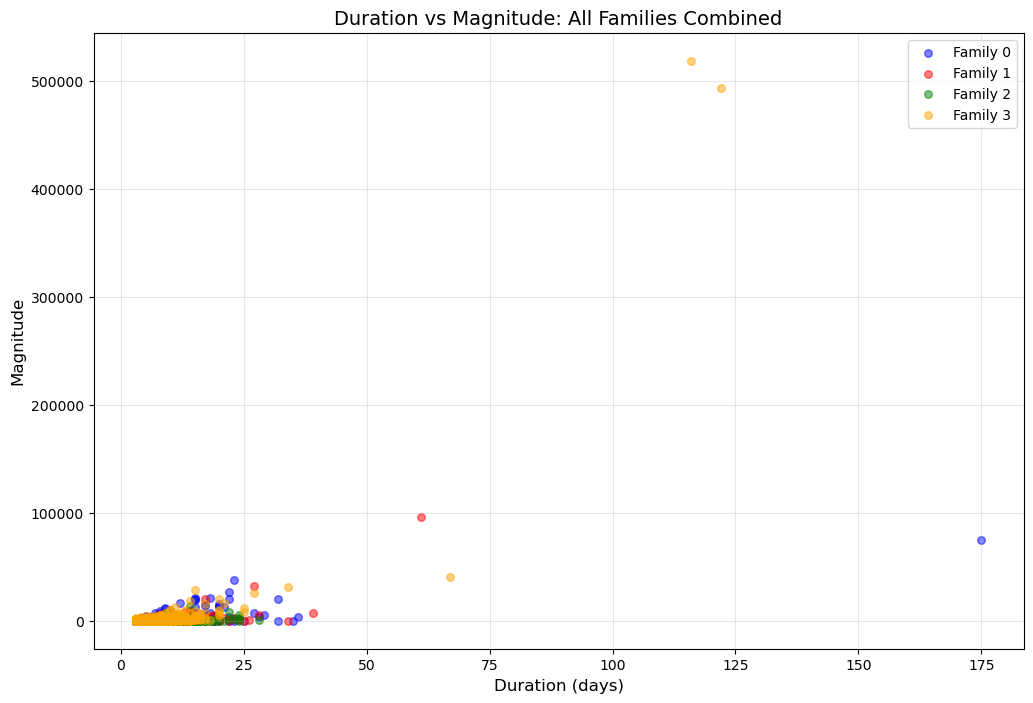

=== DURATION-MAGNITUDE CORRELATIONS ===
Family 0: r = 0.732
Family 1: r = 0.580
Family 2: r = 0.337
Family 3: r = 0.823


In [17]:
# Duration vs Magnitude relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual scatter plots
for i, (fam_id, df) in enumerate(families_clean.items()):
    axes[i//2, i%2].scatter(df['timespan'], df['HWMId_magnitude'], 
                            alpha=0.6, color=colors[i], s=30)
    
    # Calculate and plot regression line
    if len(df) > 1:
        z = np.polyfit(df['timespan'], df['HWMId_magnitude'], 1)
        p = np.poly1d(z)
        axes[i//2, i%2].plot(df['timespan'], p(df['timespan']), 
                             "--", color='red', alpha=0.7, linewidth=2)
        
        # Calculate correlation
        corr = df['timespan'].corr(df['HWMId_magnitude'])
        axes[i//2, i%2].text(0.05, 0.95, f'r = {corr:.3f}', 
                             transform=axes[i//2, i%2].transAxes,
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axes[i//2, i%2].set_xlabel('Duration (days)')
    axes[i//2, i%2].set_ylabel('Magnitude')
    axes[i//2, i%2].set_title(f'Family {fam_id}: Duration vs Magnitude')
    axes[i//2, i%2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/raj.ayush/results/final_ananananal/family_duration_magnitude_relationships.png')
plt.show()

# Combined correlation comparison
plt.figure(figsize=(12, 8))
for fam_id, df in families_clean.items():
    plt.scatter(df['timespan'], df['HWMId_magnitude'], 
                alpha=0.5, s=30, label=f'Family {fam_id}', 
                color=colors[fam_id])

plt.xlabel('Duration (days)')
plt.ylabel('Magnitude')
plt.title('Duration vs Magnitude: All Families Combined')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/raj.ayush/results/final_ananananal/family_combined_duration_magnitude.png')
plt.show()

# Correlation summary
print("=== DURATION-MAGNITUDE CORRELATIONS ===")
for fam_id, df in families_clean.items():
    if len(df) > 1:
        corr = df['timespan'].corr(df['HWMId_magnitude'])
        print(f"Family {fam_id}: r = {corr:.3f}")

In [18]:
# Statistical tests between families
print("=== STATISTICAL COMPARISONS BETWEEN FAMILIES ===")

# ANOVA tests
from scipy.stats import f_oneway, kruskal

# Duration comparison
duration_groups = [families_clean[fam_id]['timespan'].values for fam_id in range(4)]
f_stat_dur, p_val_dur = f_oneway(*duration_groups)
h_stat_dur, p_val_dur_kw = kruskal(*duration_groups)

print(f"Duration ANOVA: F={f_stat_dur:.3f}, p={p_val_dur:.6f}")
print(f"Duration Kruskal-Wallis: H={h_stat_dur:.3f}, p={p_val_dur_kw:.6f}")

# Magnitude comparison
magnitude_groups = [families_clean[fam_id]['HWMId_magnitude'].values for fam_id in range(4)]
f_stat_mag, p_val_mag = f_oneway(*magnitude_groups)
h_stat_mag, p_val_mag_kw = kruskal(*magnitude_groups)

print(f"Magnitude ANOVA: F={f_stat_mag:.3f}, p={p_val_mag:.6f}")
print(f"Magnitude Kruskal-Wallis: H={h_stat_mag:.3f}, p={p_val_mag_kw:.6f}")

print("Note: p < 0.05 suggests significant differences between families")

# Pairwise comparisons (example for magnitude)
from scipy.stats import mannwhitneyu
print("\n=== PAIRWISE MAGNITUDE COMPARISONS (Mann-Whitney U) ===")
for i in range(4):
    for j in range(i+1, 4):
        if i in families_clean and j in families_clean:
            stat, p_val = mannwhitneyu(families_clean[i]['HWMId_magnitude'], 
                                      families_clean[j]['HWMId_magnitude'])
            print(f"Family {i} vs Family {j}: U={stat:.1f}, p={p_val:.6f}")

# Summary statistics table
summary_table = pd.DataFrame({
    'Family': list(families_clean.keys()),
    'N_Events': [len(df) for df in families_clean.values()],
    'Mean_Duration': [df['timespan'].mean() for df in families_clean.values()],
    'Std_Duration': [df['timespan'].std() for df in families_clean.values()],
    'Mean_Magnitude': [df['HWMId_magnitude'].mean() for df in families_clean.values()],
    'Std_Magnitude': [df['HWMId_magnitude'].std() for df in families_clean.values()],
    'Duration_Magnitude_Corr': [df['timespan'].corr(df['HWMId_magnitude']) 
                               for df in families_clean.values()]
})

print("\n=== FAMILY SUMMARY TABLE ===")
display(summary_table.round(3))

# Export family summary
# summary_table.to_csv('/home/raj.ayush/results/final_ananananal/family_summary_statistics.csv', index=False)
print("\nFamily analysis complete! Ready for subfamily analysis.")

=== STATISTICAL COMPARISONS BETWEEN FAMILIES ===
Duration ANOVA: F=1.746, p=0.155339
Duration Kruskal-Wallis: H=14.557, p=0.002238
Magnitude ANOVA: F=2.450, p=0.061687
Magnitude Kruskal-Wallis: H=358.558, p=0.000000
Note: p < 0.05 suggests significant differences between families

=== PAIRWISE MAGNITUDE COMPARISONS (Mann-Whitney U) ===
Family 0 vs Family 1: U=546984.0, p=0.029805
Family 0 vs Family 2: U=778332.0, p=0.000000
Family 0 vs Family 3: U=847670.0, p=0.000000
Family 1 vs Family 2: U=394693.0, p=0.000000
Family 1 vs Family 3: U=406717.0, p=0.000000
Family 2 vs Family 3: U=313887.0, p=0.000000

=== FAMILY SUMMARY TABLE ===


,Family,N_Events,Mean_Duration,Std_Duration,Mean_Magnitude,Std_Magnitude,Duration_Magnitude_Corr
0,0,1408,6.024,5.902,795.767,3050.399,0.732
1,1,735,5.922,4.435,616.309,3888.967,0.580
2,2,841,6.044,3.672,246.316,793.594,0.337
3,3,1414,5.632,5.489,1479.144,19130.846,0.823



Family analysis complete! Ready for subfamily analysis.
